# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
  1
 -1
 -1
  1
 -1
  1
  1
 -1
  ⋮
 -1
  1
  1
  1
 -1
  1
  1
  1
  1

### We create a function to visualize the data

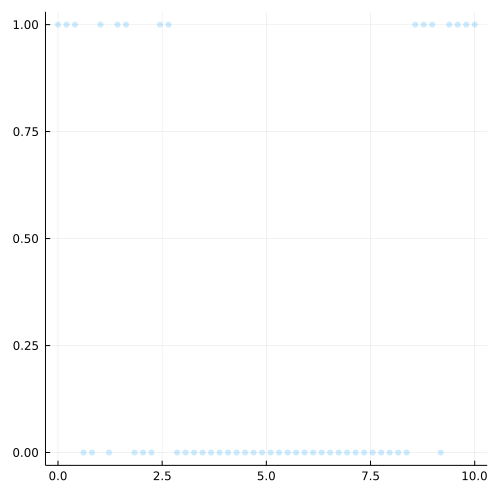

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.957019 seconds (1.82 M allocations: 103.790 MiB, 99.47% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.8805576826407759, 0.8191775834697661, 0.7548256598003532, 0.6956078642313095, 0.6487127380497932, 0.6178270014250489, 0.6026036054238679, 0.6005307802213521, 0.6094651242402491, 0.6297774066451902  …  0.9409839263547349, 0.7274639976525252, 0.6109196743478322, 0.6451376233834443, 0.7819071146728479, 0.9398060012997157, 1.0736125567472192, 1.1653074742513174, 1.2120481661572327, 1.219497846162293], θ = [0.23500762912753217, 0.2368982500736343, 0.23876940790483175, 0.24038437374971258, 0.24158662739513306, 0.24233996320371634, 0.24269974931054789, 0.24274814178796086, 0.24253853773897704, 0.24205217034436202  …  0.23305218820475276, 0.23952871670749742, 0.24250416200182282, 0.24167541399251927, 0.23799629354826224, 0.23309115776489905, 0.2284653951029307, 0.22508717942316098, 0.22330890

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:05
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:35
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:43
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:17
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:02
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:51
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:38
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:34
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:25
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.5302641488613078, 0.5659052366808892, 0.5587939926096007, 0.5660037232984753, 0.5649877145179473, 0.5902413121603204, 0.5933179805742225, 0.5564242245233593, 0.4885389438286581, 0.34937483604114483  …  -0.3085492165729514, 0.123396813758049, 0.595792059584348, 1.0206612789004978, 1.3186579151130937, 1.4938761042012603, 1.432932652852007, 1.1819218073353022, 0.8293431183145726, 0.35901795260866265]]
 [[1.2445503949236667, 1.1838178402971986, 1.171516239168049, 1.1166426851909033, 1.0368866797995642, 0.9193633420872016, 0.7527395016806209, 0.5102621959593443, 0.28833016100018105, 0.006693218322919803  …  -0.2625252914885337, 0.12687334986160204, 0.441266683438511, 0.7565080654000533, 1.0406603528510248, 1.2564242473451155, 1.410634896014164, 1.4910606347874857, 1.5159497304477398, 1.5251290805570716]]
 [[1.5294502845954203, 1.1369852117352877, 0.709399486213677, 0.28180390265926125, -0.09960187136557316, -0.4419161855222685, -0.699339873

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

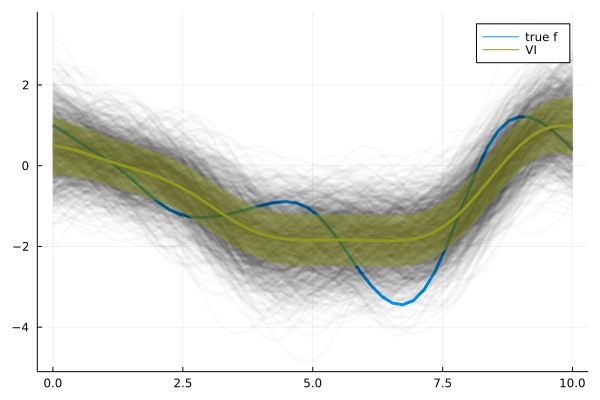

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

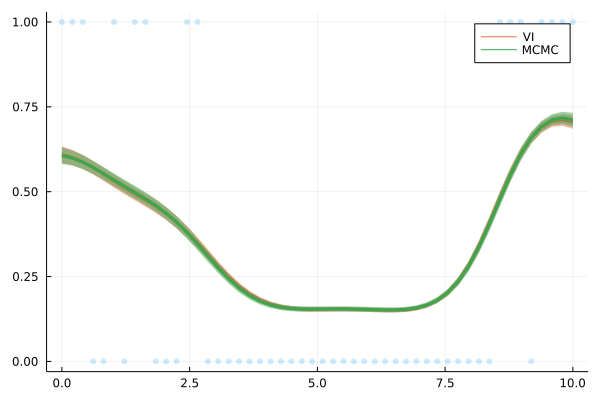

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*